# Simple Simulation Analysis

In this notebook I will analyse the output of a simple simulation. First, I load the output data of the two stations.

In [1]:
%matplotlib inline

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from model.run import Simulator, Depot, Customer

#customer_data = pd.read_csv('../output/customer_output.csv', index_col=0)
#depot_data = pd.read_csv('../output/depot_output.csv', index_col=0)

#depot_data.head()

## Run simulations

Run the simulation for several settings for the batch sizes and rates

In [2]:
# Common settings of the simulation
sim_time = 20
time_delta = 0.01

# Settings depot
customer_batch_sizes = [1, 2, 3, 4, 5]
customer_demand_rates = [0.5, 1, 1.5]

# Settings server
depot_batch_sizes = [0, 1, 2]
depot_repair_rate = 2

# Initialise empty dataframe
sim_dfs = pd.DataFrame()

# Loop over all settings
for customer_batch in customer_batch_sizes:
    for depot_batch in depot_batch_sizes:
        for customer_demand_rate in customer_demand_rates:
            # Create simulation objects
            customer = Customer(customer_batch, customer_demand_rate)
            depot = Depot(depot_batch, depot_repair_rate)

            # Link outgoing service stations
            customer.out_server = depot
            depot.out_server = customer

            # Create and run simulator
            simulator = Simulator([customer, depot], time_delta, sim_time)
            simulator.initialise()
            simulator.run()
            
            # Obtain simulator output
            sim_data = simulator.output_df()
            sim_data = sim_data.assign(customer_batch_size=customer_batch, 
                                       customer_demand_rate=customer_demand_rate,
                                       depot_batch_size=depot_batch,
                                       depot_repair_rate=depot_repair_rate)
            
            # Add sim_data
            sim_dfs = sim_dfs.append(sim_data)

100%|██████████| 2000/2000 [00:04<00:00, 484.89it/s]


## Visualisation of stock over time

The stock levels of the repairable and servicable units are recorded over time. Let's check these.

In [3]:
# Get a feeling for the data
sim_dfs.head()

# Create a column containing the complete setting
sim_dfs['pars'] = sim_dfs.apply(lambda x: 'Q_c={}, d={}, Q_d={}, r={}'.format(x['customer_batch_size'], x['customer_demand_rate'], x['depot_batch_size'], x['depot_repair_rate']), axis=1)

# Melt dataset first
sim_dfs_long = sim_dfs.melt(id_vars=['time', 'pars'], value_vars=['customer_service_stock', 'customer_repair_stock', 'depot_service_stock', 'depot_repair_stock'], var_name='inventory_type', value_name='inventory_level')
sim_dfs_long.head()

,time,pars,inventory_type,inventory_level
0,0.000000,"Q_c=1, d=0.5, Q_d=0, r=2",customer_service_stock,0.995
1,0.010005,"Q_c=1, d=0.5, Q_d=0, r=2",customer_service_stock,0.99
2,0.020010,"Q_c=1, d=0.5, Q_d=0, r=2",customer_service_stock,0.985
3,0.030015,"Q_c=1, d=0.5, Q_d=0, r=2",customer_service_stock,0.98
4,0.040020,"Q_c=1, d=0.5, Q_d=0, r=2",customer_service_stock,0.975


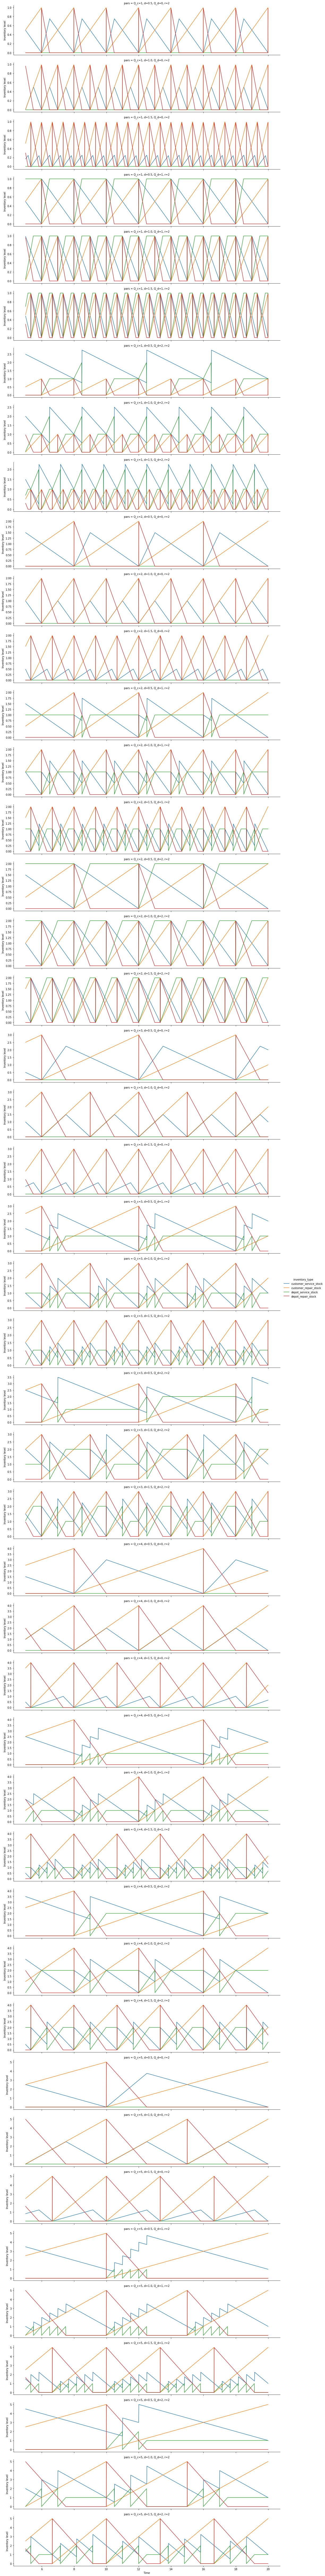

In [4]:
# Plot lines over time 
g = sns.FacetGrid(sim_dfs_long[sim_dfs_long.time > 5], col='pars', col_wrap=1, hue='inventory_type', aspect=5, sharey=False)

# Plot lines
g.map(plt.plot, 'time', 'inventory_level').add_legend().set_axis_labels('Time', 'Inventory level')

## Compute the average cycle cost

In this simple model, we assume that sending a batch from the server to the depot has a cost `c_d` and sending a batch of repairable units from the depot to the server costs `c_r`. In general we have that `c_r` > `c_d`, since the reverse flow is typically less efficient. Besides, set-up costs for orders, a holding costs of `h_d` per unit per unit of time for stock of servicable units at the depot has to be paid. In case of a shortage, a backlogging cost of `b_d` per unit per unit of time is incurred. For now, I do not assume any holding cost for the repairable units.

In [36]:
# Cost structure
c_d = 1
c_r = 3
h_d = 0.02
b_d = 0.4

# In this case, the cycle length can be easily eye-balled.

# Take data for one cycle
cycle_data = all_data.query('5 <= time <= 10')

# Get all order events
customer_events = pd.read_csv('../output/customer_events.csv', index_col=0).query('5 <= time <= 10')
depot_events = pd.read_csv('../output/depot_events.csv', index_col=0).query('5 <= time <= 10')

# Count orders
n_order_customer = customer_events.shape[0]
n_order_depot = depot_events.shape[0]

# Inventory in numpy
customer_stock = cycle_data.customer_service_stock.to_numpy()

# Compute costs
total_order_costs = n_order_customer * c_r + n_order_depot * c_d
total_var_costs = customer_stock.clip(min=0).sum() * h_d + np.sum(-customer_stock.clip(max=0)) * b_d

print(total_order_costs + total_var_costs)

19.950000000001072


### Average inventory levels per cycle

In [ ]:
cycle_data.